In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format='retina'

BEST_SINGLE_MNIST_XS = {
    "trial": "best_single_mnist_xs",
    "accuracy": 93.04,
    "loss": 0.236, 
    "ensemble_size": 1,
    "model_size": "mnist_xs",
}
BEST_SINGLE_MNIST_S = {
    "trial": "best_single_mnist_s",
    "accuracy": 95.83,
    "loss": 0.152, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "mnist_s",
}
BEST_SINGLE_MNIST_M = {
    "trial": "best_single_mnist_m",
    "accuracy": 96.57,
    "loss": 0.127, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "mnist_m",
}
BEST_SINGLE_MNIST_L = {
    "trial": "best_single_mnist_l",
    "accuracy": 97.78,
    "loss": 0.089, # TODO: Update loss
    "ensemble_size": 1,
    "model_size": "mnist_l",
}
BEST_SINGLE_MNIST_XS_DF = pd.DataFrame(BEST_SINGLE_MNIST_XS, index=[0])
BEST_SINGLE_MNIST_S_DF = pd.DataFrame(BEST_SINGLE_MNIST_S, index=[0])
BEST_SINGLE_MNIST_M_DF = pd.DataFrame(BEST_SINGLE_MNIST_M, index=[0])
BEST_SINGLE_MNIST_L_DF = pd.DataFrame(BEST_SINGLE_MNIST_L, index=[0])

In [2]:
def parse_single_model_experiment(experiment_dir):
    """
    Parse single model experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,model_size\n")
    for acc_f in accuracy_files:
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        # Get model size
        if "mnist_xs" in txt_file:
            model_size = "mnist_xs"
        elif "mnist_s1.1" in txt_file:
            model_size = "mnist_s1.1"
        elif "mnist_s" in txt_file:
            model_size = "mnist_s"
        elif "mnist_m" in txt_file:
            model_size = "mnist_m"
        elif "mnist_m1.1" in txt_file:
            model_size = "mnist_m1.1"
        elif "mnist_m1.2" in txt_file:
            model_size = "mnist_m1.1"
        elif "mnist_l" in txt_file:
            model_size = "mnist_l"
        elif "mnist_l1.1" in txt_file:
            model_size = "mnist_l1.1"
        else:
            raise ValueError("No model size captured from logs")
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def parse_ensembling_experiment(experiment_dir):
    """
    Parse ensemble learning experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    for acc_f in accuracy_files:
        # Example accuracy file
        # averaging_small_ensemble_size2_loss=0.838_accuracy.txt
        # Get accuracy
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        ensemble_size = int(re.findall(f"\d+", txt_file)[0])
        # Get model size
        if "small" in txt_file:
            model_size = "mnist_s"
        elif "xs" in txt_file:
            model_size = "mnist_xs"
        else:
            raise ValueError("No model size captured from logs")
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f}, {ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def add_single_model_data(df):
    """
    Concat single model dataframes to given dataframe
    """
    df = pd.concat([df, BEST_SINGLE_MNIST_XS_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MNIST_S_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MNIST_M_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MNIST_L_DF], ignore_index=True)
    return df

## Single Models

In [3]:
experiment_dir = "../mnist_single_models"
df = parse_single_model_experiment(experiment_dir)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
df

,trial,accuracy,loss,model_size
0,mnist_l1.1,97.78,0.089,mnist_l
1,mnist_m1.1,97.57,0.100,mnist_m
2,mnist_m,96.57,0.127,mnist_m
3,mnist_l,96.48,0.151,mnist_l
4,mnist_s,95.83,0.152,mnist_s
5,mnist_m1.2,94.07,0.211,mnist_m
6,mnist_s1.1,93.97,0.213,mnist_s1.1
7,mnist_xs,93.04,0.236,mnist_xs


## Averaging

In [4]:
experiment_dir = "../averaging"
df = parse_ensembling_experiment(experiment_dir)
df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
averaging_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,best_single_mnist_l,97.78,0.089,1,mnist_l
1,averaging_xs_ensemble_size64,97.50,0.153,64,mnist_xs
2,averaging_small_ensemble_size32,97.50,0.123,32,mnist_s
3,averaging_small_ensemble_size16,97.20,0.118,16,mnist_s
4,averaging_xs_ensemble_size32,97.16,0.135,32,mnist_xs
5,averaging_small_ensemble_size8,96.79,0.111,8,mnist_s
6,averaging_xs_ensemble_size16,96.79,0.130,16,mnist_xs
7,best_single_mnist_m,96.57,0.127,1,mnist_m
8,averaging_xs_ensemble_size8,96.26,0.134,8,mnist_xs
9,averaging_small_ensemble_size4,96.00,0.133,4,mnist_s


,trial,accuracy,loss,ensemble_size,model_size
0,best_single_mnist_l,97.78,0.089,1,mnist_l
1,averaging_xs_ensemble_size64,97.50,0.153,64,mnist_xs
2,averaging_small_ensemble_size32,97.50,0.123,32,mnist_s
3,averaging_small_ensemble_size16,97.20,0.118,16,mnist_s
4,averaging_xs_ensemble_size32,97.16,0.135,32,mnist_xs
5,averaging_small_ensemble_size8,96.79,0.111,8,mnist_s
6,averaging_xs_ensemble_size16,96.79,0.130,16,mnist_xs
7,best_single_mnist_m,96.57,0.127,1,mnist_m
8,averaging_xs_ensemble_size8,96.26,0.134,8,mnist_xs
9,averaging_small_ensemble_size4,96.00,0.133,4,mnist_s


/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/olivia/miniconda3/envs/jupyter/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


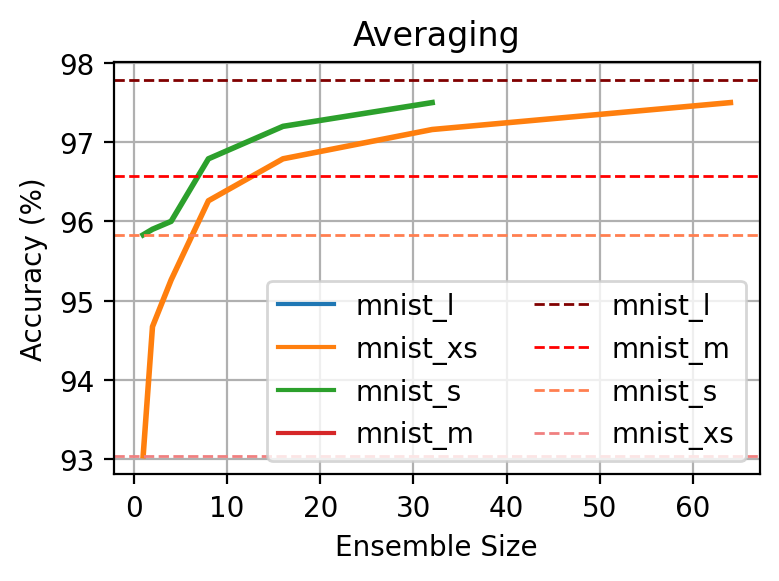

In [5]:
"""
Line plot of accuracy vs ensemble size
"""
# plot_df = df.loc[df["model_size"].isin(["small", "medium", "large"])]
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
    # label="JSC-S Ensemble"
)
plt.axhline(y=BEST_SINGLE_MNIST_L["accuracy"], linewidth=1, linestyle="--", color="maroon", label="mnist_l")
plt.axhline(y=BEST_SINGLE_MNIST_M["accuracy"], linewidth=1, linestyle="--", color="red", label="mnist_m")
plt.axhline(y=BEST_SINGLE_MNIST_S["accuracy"], linewidth=1, linestyle="--", color="coral", label="mnist_s")
plt.axhline(y=BEST_SINGLE_MNIST_XS["accuracy"], linewidth=1, linestyle="--", color="lightcoral", label="mnist_xs")
ax.grid()
ax.legend(ncol=2)
ax.set_title("Averaging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
# ax.set_xscale("log")
fig.tight_layout()
plt.savefig("averaging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("averaging_acc_v_ensemble_size_lineplot.png")